## The following notebook is to demonstrate the use of Tensorflow Dataset api
Data is usually fed into tensorflow session using feed dict. The batches and shuffle need to manually created before feeding.The dataset api provides a simple but intuitive data pipeline to feed the data.  
The api also provides various other functions to do transformation and can be built alongside python data pipeline to work.

In [1]:
# Import the libraries
import tensorflow as tf
import numpy as np
from sklearn.datasets import make_moons
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# For the demonstration, we are are going to use digits data in sklearn
x,y=load_digits(return_X_y=True)
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.3,random_state=101)
print(x_train.shape,x_test.shape)

(1257, 64) (540, 64)


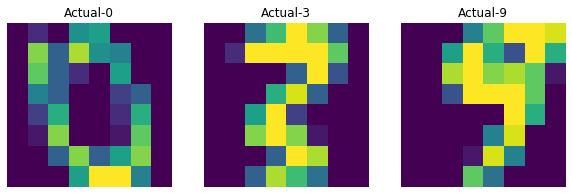

In [3]:
def plot_data(x_train,y_train,prediction=None):
    imgs=np.random.choice(x_train.shape[0],3)
    fig,ax=plt.subplots(nrows=1,ncols=3,figsize=(10,4.5))
    for i,img in enumerate(imgs):
        ax[i].imshow(x_train[img].reshape(-1,8))
        if prediction is not None:
            ax[i].set_title("Actual-{}  & Prediction- {}".format(y_train[img],prediction[img]))
        else:
            ax[i].set_title("Actual-{}".format(y_train[img]))
        ax[i].set_axis_off()
    plt.show()
plot_data(x_train,y_train)

Create a tensorflow graph. We'll use fully connected layers.

In [4]:
tf.reset_default_graph()

In [5]:
def dense_layer(inpt, units,layer_name):
    with tf.variable_scope(layer_name):
        weights=tf.get_variable(shape=[int(inpt.get_shape()[1]),units],name='weights',dtype=tf.float64)
        biases=tf.get_variable(shape=[units],name='biases',initializer=tf.zeros_initializer(),dtype=tf.float64)
        return tf.add(tf.matmul(inpt,weights),biases)

In [6]:
def nn_model(in_data):
    fc1=dense_layer(in_data,64,layer_name='fc1')
    fc1_act=tf.nn.relu(fc1)
    fc2=dense_layer(fc1_act,32,layer_name='fc2')
    fc2_act=tf.nn.relu(fc2)
    fc3=dense_layer(fc2_act,10,layer_name='fc3')
    output=tf.nn.softmax(fc3)
    return output

Create placeholders for train and test data and batch size.

In [7]:
x_pl,y_pl=tf.placeholder(dtype=tf.float64,shape=[None,64]),tf.placeholder(dtype=tf.int64,shape=[None])
batch_size=tf.placeholder(dtype=tf.int64)

In [8]:
# Here we from_tensor_slices function from dataset api. This is used with numpy arrays to create slices of data.
# The alternative includes from_generator which can be with custom python generator func
dx=tf.data.Dataset.from_tensor_slices(x_pl)
dy=tf.data.Dataset.from_tensor_slices(y_pl)
# Onehot encoding for labels
dy_onehot=dy.map(lambda z:tf.one_hot(z,depth=10))
# Combine the features and target labels together and chain shuffle, repeat and batch_size to it.
# repeat takes an argument which is for how many times, the data should be repeated. Here its inifinte.
dataset=tf.data.Dataset.zip((dx,dy_onehot)).repeat().batch(batch_size)

In [9]:
# Make an initializable iterator. At run time, it can be either initialized with train data or test data
iterator=dataset.make_initializable_iterator()
next_element=iterator.get_next()

Next element is like a tuple as we have zipped the features and labels. next_element[0] can be visualized as x_train[batch_size,64]. During session run, tensorflow will keep iterating over different batches

In [10]:
# Defining the model
logits=nn_model(next_element[0])

In [11]:
# Defining the loss
loss=tf.reduce_sum(tf.nn.softmax_cross_entropy_with_logits_v2(labels=next_element[1],logits=logits))

In [12]:
# Defining the optimizer
optimizer=tf.train.AdamOptimizer().minimize(loss)

In [13]:
# Define the accuracy
accuracy=tf.reduce_mean(tf.cast(tf.equal(tf.argmax(logits,axis=1),tf.argmax(next_element[1],axis=1)),tf.float64))

In [17]:
epochs=600
with tf.Session() as sess:
    # Initialzed the variables
    init=tf.global_variables_initializer()
    sess.run(init)
    # Initialize the dataset iterator with training data
    sess.run(iterator.initializer,feed_dict={x_pl:x_train,y_pl:y_train,batch_size:128})
    # Train the model
    for i in range(epochs):
        _,l,acc=sess.run([optimizer,loss,accuracy])
        if i%50==0:
            print("Epoch: {}, loss: {:.3f}, training accuracy: {:.2f}%".format(i, l, acc * 100))
    # The model run is completed.
    # Now we switch to test data fed to the iterator
    sess.run(iterator.initializer,feed_dict={x_pl:x_test,y_pl:y_test,batch_size:x_test.shape[0]})
    # Get test accuracy and predictions
    valid_acc=sess.run([accuracy])
    logits_valid=sess.run([logits])
    predict=np.argmax(logits_valid[0],axis=1)
    print("Validation accuracy = {:.3f}%".format(valid_acc[0]*100))

Epoch: 0, loss: 304.313, training accuracy: 3.91%
Epoch: 50, loss: 235.814, training accuracy: 64.06%
Epoch: 100, loss: 213.974, training accuracy: 81.25%
Epoch: 150, loss: 202.834, training accuracy: 88.28%
Epoch: 200, loss: 198.626, training accuracy: 91.41%
Epoch: 250, loss: 196.377, training accuracy: 92.97%
Epoch: 300, loss: 195.158, training accuracy: 93.75%
Epoch: 350, loss: 199.917, training accuracy: 89.84%
Epoch: 400, loss: 200.894, training accuracy: 89.06%
Epoch: 450, loss: 201.920, training accuracy: 88.28%
Epoch: 500, loss: 202.588, training accuracy: 87.50%
Epoch: 550, loss: 200.718, training accuracy: 89.06%
Validation accuracy = 96.296%


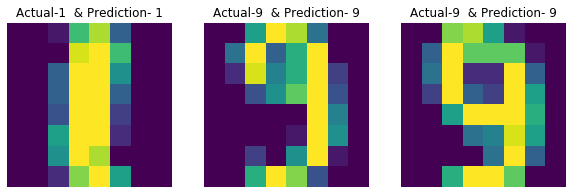

In [15]:
plot_data(x_test,y_test,predict)